# <font color='indigo'> Variational Quantum Eigensolver (VQE) in Pauli form </font>

Here we employ VQE to find the ground state of a Hamiltonian which is already in the form of linear combination of four Pauli matrices:
$\mathcal{H} = a X + b Y + c Z + d I$.

For Qiskit IBM documentation, visit:  https://learning.quantum.ibm.com/tutorial/variational-quantum-eigensolver

## Compare Qiskit's `NumPyEigensolver` with `numpy.linalg.eig`

In [2]:
import numpy as np
from qiskit_algorithms import NumPyEigensolver
from qiskit.quantum_info import SparsePauliOp
from random import random


# Define coefficients
a, b, c, d = 1, 2, 3, 4

# We can randomize the coefficients as well
scale = 10
a, b, c, d = scale*random(), scale*random(), scale*random(), scale*random()
a, b, c, d = round(a,2), round(b,2), round(c,2), round(d,2)

# Print the Hamiltonian with coeffcient avlues
print(f'H = aX + bY + cZ + dI where a = {a}, b ={b}, c = {c}, d = {d}')

# Construct Hamiltonian H = a*X + b*Y + c*Z + d*I using SparsePauliOp
H_op = SparsePauliOp.from_list([
    ("X", a),
    ("Y", b),
    ("Z", c),
    ("I", d)
])


# Convert to matrix for NumPy computation
H_matrix = H_op.to_matrix()
print('Hamiltonian in matrix form:',H_matrix)

# Method 1: Using NumPy's linear algebra module
eigenvalues_np, _ = np.linalg.eigh(H_matrix)
print("Eigenenergies (NumPy):", eigenvalues_np)

# Method 2: Using Qiskit's NumPyEigensolver
eigensolver = NumPyEigensolver(k=2)
result = eigensolver.compute_eigenvalues(H_op)
eigenvalues_qiskit = result.eigenvalues
print("Eigenenergies (Qiskit):", eigenvalues_qiskit)
#print("Imaginary parts (Qiskit):", eigenvalues_qiskit.imag)

# Compare results (accounting for possible different ordering)
# Find absolute differences for all possible pairings
diff1 = np.abs(eigenvalues_np - eigenvalues_qiskit)
diff2 = np.abs(eigenvalues_np - eigenvalues_qiskit[::-1])
difference = np.minimum(diff1, diff2)
print("Absolute difference between NumPy and Qiskit results:", difference)

H = aX + bY + cZ + dI where a = 2.15, b =8.94, c = 1.52, d = 6.8
Hamiltonian in matrix form: [[8.32+0.j   2.15-8.94j]
 [2.15+8.94j 5.28+0.j  ]]
Eigenenergies (NumPy): [-2.51968347 16.11968347]
Eigenenergies (Qiskit): [-2.51968347 16.11968347]
Absolute difference between NumPy and Qiskit results: [0. 0.]


## Now let's solve the same Hamiltonian using VQE

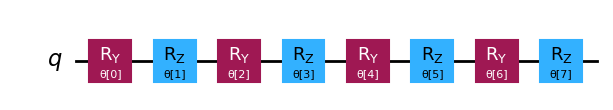

No. of parameters in ansatz: 8


/var/folders/3m/pc44t30x60gd3bj_3f670_yw0000gn/T/ipykernel_14185/3470515873.py:14: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  estimator = Estimator()


VQE Eigenvalue: -2.519683466239635


In [3]:
from qiskit_algorithms import VQE
from qiskit.primitives import Estimator  # Use the Primitive Estimator
from qiskit.circuit.library import EfficientSU2
from qiskit_algorithms.optimizers import SPSA, COBYLA

# === VQE Setup ===
# Step 1: Ansatz
ansatz = EfficientSU2(H_op.num_qubits, entanglement="linear")
display(ansatz.decompose().draw("mpl", style="iqp"))
num_params = ansatz.num_parameters
print('No. of parameters in ansatz:',num_params)

# Step 2: Measurement (expectation value)
estimator = Estimator() 
                # Primitive Estimator (you may get warning)
    
# Step 3: Optimization of expectation value    
#optimizer = SPSA(maxiter=100) 
optimizer = COBYLA(maxiter=100)

# Now VQE
vqe = VQE(
    estimator=estimator,  
    ansatz=ansatz,
    optimizer=optimizer,
    initial_point=np.random.rand(ansatz.num_parameters)
)

vqe_result = vqe.compute_minimum_eigenvalue(H_op)
print("VQE Eigenvalue:", vqe_result.eigenvalue)

## Running on IBM hardware !(Below part needs to be modified)!

In [4]:
# runtime imports
from qiskit_ibm_runtime import QiskitRuntimeService, Session
from qiskit_ibm_runtime import EstimatorV2 as Estimator

# To run on hardware, select the backend with the fewest number of jobs in the queue
service = QiskitRuntimeService(channel="ibm_quantum")
backend = service.least_busy(operational=True, simulator=False)

IBMNotAuthorizedError: '401 Client Error: Unauthorized for url: https://auth.quantum.ibm.com/api/users/loginWithToken. This version of platform has been sunset. Create an account or sign in to the upgraded IBM Quantum Platform at https://quantum.cloud.ibm.com, Error code: 3447.'

### Optimize through ISA circuits
To reduce the total job execution time, Qiskit primitives only accept circuits (ansatz) and observables (Hamiltonian) that conform to the instructions and connectivity supported by the target QPU (referred to as instruction set architecture (ISA) circuits and observables).

In [56]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

target = backend.target
pm = generate_preset_pass_manager(target=target, optimization_level=3)

ansatz_isa = pm.run(ansatz)

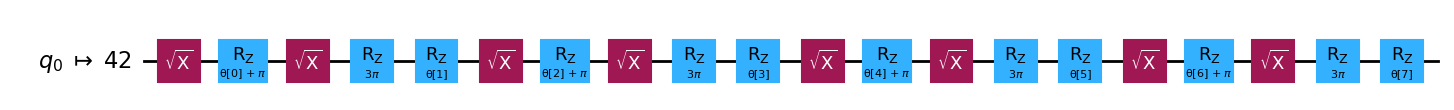

In [57]:
ansatz_isa.draw(output="mpl", idle_wires=False, style="iqp")

### ISA observable

Transform the Hamiltonian to make it backend-compatible before running jobs with 
Runtime Estimator V2
. Perform the transformation by using the apply_layout method of SparsePauliOp object.

In [58]:
hamiltonian_isa = H_op.apply_layout(layout=ansatz_isa.layout)

### Cost function

In [59]:
def cost_func(params, ansatz, hamiltonian, estimator):
    """Return estimate of energy from estimator

    Parameters:
        params (ndarray): Array of ansatz parameters
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (EstimatorV2): Estimator primitive instance
        cost_history_dict: Dictionary for storing intermediate results

    Returns:
        float: Energy estimate
    """
    pub = (ansatz, [hamiltonian], [params])
    result = estimator.run(pubs=[pub]).result()
    energy = result[0].data.evs[0]

    cost_history_dict["iters"] += 1
    cost_history_dict["prev_vector"] = params
    cost_history_dict["cost_history"].append(energy)
    print(f"Iters. done: {cost_history_dict['iters']} [Current cost: {energy}]")

    return energy

In [60]:
cost_history_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
}

### Specify a random initialized set of parameters

In [61]:
x0 = 2 * np.pi * np.random.random(num_params)

In [62]:
x0

array([1.38696931, 3.73842881, 3.57548501, 0.4758309 , 1.48644264,
       1.35757732, 5.06452395, 1.15582661])

### Execute through runtime Estimator

In [63]:
with Session(backend=backend) as session:
    estimator = Estimator(mode=session)
    estimator.options.default_shots = 10000

    res = minimize(
        cost_func,
        x0,
        args=(ansatz_isa, hamiltonian_isa, estimator),
        method="cobyla",
    )

qiskit_runtime_service.check_pending_jobs:WARNING:2025-04-14 03:15:56,034: The pending jobs limit has been reached. Waiting for job <RuntimeJobV2('cykvy9101rbg008gek8g', 'estimator')> to finish before submitting the next one.


IBMRuntimeError: 'Failed to run program: \'409 Client Error: Conflict for url: https://api.quantum.ibm.com/runtime/jobs. {"errors":[{"message":"You have reached the limit of 3 pending  jobs. Please wait for a job to complete or cancel one before submitting anything new.","code":3458,"solution":"Wait until some previous jobs were finished. You can cancel pending jobs to run new jobs.","more_info":"https://docs.quantum-computing.ibm.com/errors"}]}\''

In [ ]:
res

In [ ]:
all(cost_history_dict["prev_vector"] == res.x)

In [ ]:
all(cost_history_dict["prev_vector"] == res.x)

### Plot progress through call history

In [ ]:
fig, ax = plt.subplots()
ax.plot(range(cost_history_dict["iters"]), cost_history_dict["cost_history"])
ax.set_xlabel("Iterations")
ax.set_ylabel("Cost")
plt.draw()